<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span><ul class="toc-item"><li><span><a href="#Imports-and-configurations" data-toc-modified-id="Imports-and-configurations-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports and configurations</a></span></li><li><span><a href="#Data-set-preparation:-LARGE" data-toc-modified-id="Data-set-preparation:-LARGE-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data set preparation: LARGE</a></span></li></ul></li><li><span><a href="#Run-models" data-toc-modified-id="Run-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Run models</a></span><ul class="toc-item"><li><span><a href="#Factor-Analysis" data-toc-modified-id="Factor-Analysis-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Factor Analysis</a></span></li><li><span><a href="#scVI" data-toc-modified-id="scVI-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>scVI</a></span></li><li><span><a href="#m-pCMF" data-toc-modified-id="m-pCMF-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>m-pCMF</a></span></li><li><span><a href="#ZINBayes" data-toc-modified-id="ZINBayes-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>ZINBayes</a></span></li></ul></li><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot results</a></span></li></ul></div>

# Initialization

## Imports and configurations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %matplotlib inline

from zinbayes.zinbayes import ZINBayes

from pCMF import mpCMF

from state_of_art.scVI.scvi import scVI
from state_of_art.ZIFA.zifa import ZIFA
from state_of_art.ZINB_WaVE.zinb_wave import ZINB_WaVE
from state_of_art.pCMF.pcmf import pCMF

from misc.model_wrapper import ModelWrapper
from misc import print_utils, plot_utils

import edward as ed
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from scipy.stats import gaussian_kde, pearsonr
import pandas as pd
from sklearn.decomposition import FactorAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

from edward.models import Beta, RelaxedBernoulli, Gamma, Poisson, Dirichlet, Mixture, Categorical, TransformedDistribution, Normal, PointMass

plt.style.use('seaborn-whitegrid')

In [3]:
# scatter plots style
s = 30
alpha = 0.5

## Data set preparation: LARGE

In [4]:
from scvi.dataset import BrainLargeDataset

In [5]:
brain_large = BrainLargeDataset(subsample_size=20000)

File data/genomics.h5 already downloaded
Preprocessing Brain Large data
720 genes subsampled
1306127 cells subsampled
Finished preprocessing data


In [6]:
X = brain_large.X

In [7]:
X_train, X_test = train_test_split(X, test_size=10000, shuffle=True) 

# Run models
For each model, we need:
* 5-fold cross-validation to compute the held-out data log-likelihood

In [8]:
K = 10

## Factor Analysis

In [9]:
obj = FactorAnalysis(n_components=K)
fa = ModelWrapper(obj, X_train, X_test=X_test, name='FA', do_imp=False, log_data=True)
fa.run(do_dll=True, do_holl=True, verbose=True)

Running FA...
Some arguments were ignored by FactorAnalysis.
Running .fit_transform() without keyword arguments.
Evaluating train-data log-likelihood...
Evaluating test-data log-likelihood...
Done.


In [11]:
fa.test_ll

-1193.3283711644551

## scVI

In [232]:
obj = scVI(n_components=K, n_hidden=128, batch_size=128, lr=0.001, X_test=X_test, validation=True)
scvi = ModelWrapper(obj, X_train, X_test=X_test, name='scVI')
scvi.run(max_iter=120, max_time=60*60, do_silh=False, do_dll=True, do_holl=True, do_tsne=False, verbose=True)

Running scVI...
Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
Will apply cell-specific scalings
1 hidden layers at 128 each for a final 10 latent space
Evaluating train-data log-likelihood...75. Elapsed: 0h1m11s
Evaluating test-data log-likelihood...
Done.


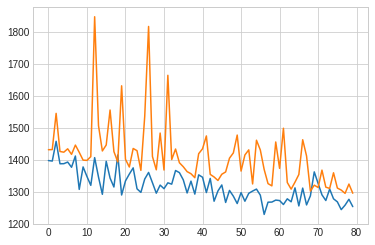

In [234]:
plt.plot(scvi.model_inst.result['t_loss'][40:])
plt.plot(scvi.model_inst.result['v_loss'][40:])

## m-pCMF

In [ ]:
mpcmf = mpCMF(X_train, Y_test=X_test, n_components=K, scalings=True, sparsity=False, 
                  zero_inflation=True, empirical_bayes=True, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=True)
mpcmf.run(max_iter=20, max_time=60*10, do_holl=False, do_dll=True, 
          do_tsne=False, calc_test=True, verbose=True)

m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Running m-pCMF...


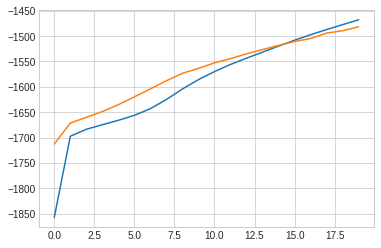

In [297]:
plt.plot(mpcmf.inf.elbo_it[:])
plt.plot(mpcmf.inf.test_elbo_it[:])

## ZINBayes

In [320]:
obj = ZINBayes(n_components=K, zero_inflation=True, n_mc_samples=10, test_iterations=500, 
               optimizer=None)
zinbayes = ModelWrapper(obj, X_train, X_test=X_test, name='ZINBayes', do_imp=False)
zinbayes.run(max_iter=500, do_silh=True, do_tsne=False, do_dll=True, do_holl=True, verbose=True)

Considering zero-inflation.
Running ZINBayes...
170/500 [ 34%] ██████████                     ETA: 910s | Loss: 1319.010

KeyboardInterrupt: 

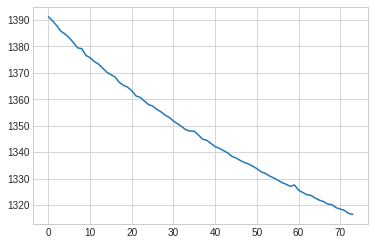

In [323]:
plt.plot(zinbayes.model_inst.loss_dict['t_loss'][100:])
plt.plot(zinbayes.model_inst.loss_dict['v_loss'][:])

# Plot results

In [ ]:
colors = sns.color_palette("Set1", 10, desat=.7) # this is a list of 10 colors

# We must choose what color to assign to each model
model_list_ll = [zinbayes, scvi, mpcmf, fa]

# Colors
color_list_ll = [colors[0], colors[2], colors[4], colors[6]]
hatch_list_ll = ['//', None, '//', None]

In [ ]:
plt.figure(figsize=(10, 6))
ax = plt.axes()
ax = plot_utils.loglikelihood_barplot(model_list_ll, colors=color_list_ll, show_legend=True, hatches=hatch_list_ll,
                            title=None, ax=ax);